## **MAGIC TELESCOPE**

Magic telescope is a Cherenkov gamma telescope placed in Roque de los Muchachos Observatory, at La Palma, which observes high energy gamma rays, taking advantage of the radiation emitted by charged particles, when they traversing the atmosphere. When electromagnetic showers are generated, gamma rays coming from the Cherenkov effect are produced. This Cherenkov radiation (from visible to UV wavelengths) leaks through the atmosphere and gets recorded in the Magic Telescope detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, in the range from few hundreds to some 10000 Cherenkov photons get collected in patterns (called the shower image) that allows to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background). Usually, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions. Through this methods it is possible to know if the shower is generated by a gamma or an hadron. This project aims predict the source of the shower through machine learning

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
%matplotlib inline
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

### Dataset **MagicTelescope**

The data set used can be found on OpenML and was generated by a Mont Carlo generetor program called CORSIKA, that consider the imaging technique previously mentioned. The code simulate the registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope and it was run with parameters allowing to observe events with energies below 50 GeV.

Attribute Information:



1.   fLength: continuous # major axis of ellipse [mm]
2.   fWidth: continuous # minor axis of ellipse [mm]
3.   fSize: continuous # 10-log of sum of content of all pixels [in #phot]
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio]
5. fConc1: continuous # ratio of highest pixel over fSize [ratio]
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm]
7. fM3Long: continuous # 3rd root of third moment along major axis [mm]
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm]
9. fAlpha: continuous # angle of major axis with vector to origin [deg]
10. fDist: continuous # distance from origin to center of ellipse [mm]
11. class: g,h # gamma (signal), hadron (background)



D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers, Forschungszentrum Karlsruhe FZKA 6019 (1998).

In [ ]:
data = fetch_openml('MagicTelescope')

In [ ]:
X, y = data['data'], data['target']

Here there are some information about the dataset: its features name and the dataset shape.

In [ ]:
print(data['feature_names'])
print(X.shape, y.shape)

['fLength:', 'fWidth:', 'fSize:', 'fConc:', 'fConc1:', 'fAsym:', 'fM3Long:', 'fM3Trans:', 'fAlpha:', 'fDist:']
(19020, 10) (19020,)


To visualize first five rows of the dataset

In [ ]:
print(X[:5])
print(y[:5])

   fLength:   fWidth:  fSize:  fConc:  ...  fM3Long:  fM3Trans:  fAlpha:    fDist:
0   28.7967   16.0021  2.6449  0.3918  ...   22.0110    -8.2027  40.0920   81.8828
1   31.6036   11.7235  2.5185  0.5303  ...   23.8238    -9.9574   6.3609  205.2610
2  162.0520  136.0310  4.0612  0.0374  ...  -64.8580   -45.2160  76.9600  256.7880
3   23.8172    9.5728  2.3385  0.6147  ...   -6.4633    -7.1513  10.4490  116.7370
4   75.1362   30.9205  3.1611  0.3168  ...   28.5525    21.8393   4.6480  356.4620

[5 rows x 10 columns]
0    g
1    g
2    g
3    g
4    g
Name: class:, dtype: category
Categories (2, object): ['g', 'h']


Find the count of events for backgrounf (h) and signal (g)

In [ ]:
y.value_counts(ascending=True)

h     6688
g    12332
Name: class:, dtype: int64

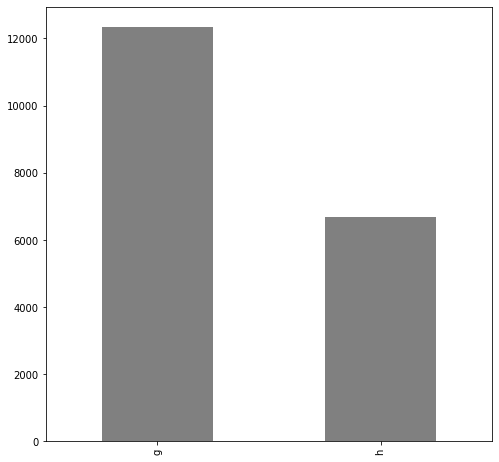

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
y.value_counts().plot(kind='bar', facecolor='gray')

Since the y target consist of an array of strings ['h', 'g'], there is the necessity to to make this a "One Hot" encoding for the training. 

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y,2)

# Create the **model**

Model thai I chose is made by 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use relu (Rectified Linear Unit) activation. ReLu is a linear function that will output the input directly if it is positive, otherwise, it will output zero. It is used in many neural networks because a model which uses it, is easier to train and often achieves better performance. It is add an output layer with 2 neurons (one for each class), then finish with Softmax activation.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import load_model

In [ ]:
model = Sequential()
model.add(Dense(64, input_shape=(10,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(2, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## **Training the model**

First of all, the the dataset is split into training and validation sets:

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

To train the model I used the Adaptive Momentum estimation (Adam) optimizer with categorical crossentropy loss.   
Adam is a method for efficient stochastic optimization that only requires first-order gradients with little memory requirement.

In [ ]:
from callbacks import all_callbacks
train = True
if train:
  adam = Adam(learning_rate=0.0001)
  model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
  callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_1')
  model.fit(X_train_val, y_train_val, batch_size=1024, epochs=100, validation_split=0.25, shuffle=True,callbacks = callbacks.callbacks)
else:
  from tensorflow.keras.models import load_model
  model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/100
11/12 [==========================>...] - ETA: 0s - loss: 10.2984 - accuracy: 0.3678 
***callbacks***
saving losses to model_1/losses.log

Epoch 00001: val_loss improved from inf to 6.27498, saving model to model_1/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 6.27498, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

12/12 [==============================] - 1s 36ms/step - loss: 10.2613 - accuracy: 0.3683 - val_loss: 6.2750 - val_accuracy: 0.4414 - lr: 1.0000e-04
Epoch 2/100
 1/12 [=>............................] - ETA: 0s - loss: 6.5580 - accuracy: 0.4336
***callbacks***
saving losses to model_1/losses.log

Epoch 00002: val_loss improved from 6.27498 to 3.13572, saving model to model_1/KERAS_check_best_model.h5

Epoch 00002: val_loss improved from 6.27498 to 3.13572, saving model to mode

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 64)                704       
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 fc2 (Dense)                 (None, 32)                2080      
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (Dense)                 (None, 32)                1056      
                                                                 
 relu3 (Activation)          (None, 32)                0         
                                                                 
 output (Dense)              (None, 2)                 6

##**Predictions**

Final part plans to know the accuracy of the model using the validation set.

In [ ]:
predictions = model.predict(X_test)

## Evaluation of the model.

Predictions are compared to the expected results in the validation set, then calculate classification accuracy.

In [ ]:
from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))))

Accuracy: 0.7744479495268138


Classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers a ROC curve has to be used. 

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import pandas as pd
import itertools
from Plotting import makeRoc, plot_confusion_matrix, rocData

### Plot the Receiver Operating Characteristic (ROC) curve

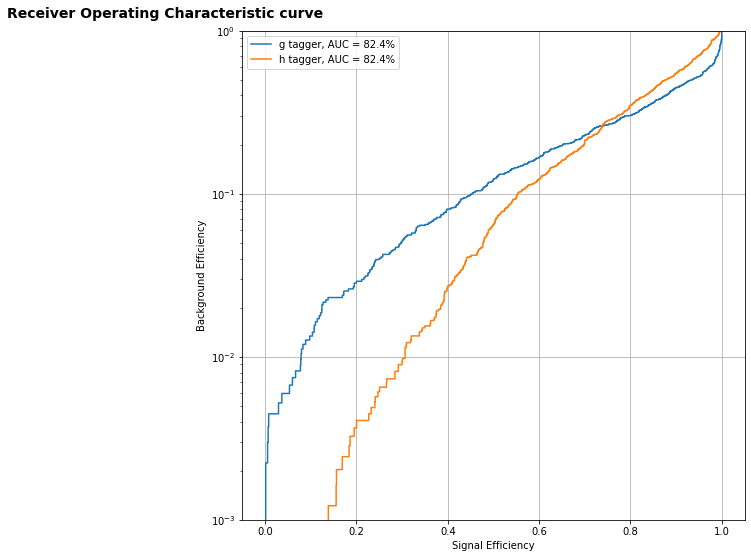

In [ ]:
plt.figure(figsize=(9,9))
_ = makeRoc(y_test, predictions, le.classes_)

### **Plot the confusion matrix**

Confusion matrix provides an indication of the errors made.  It reports the number of true positives, false negatives, false positives, and true negatives. This allows more detailed analysis than simply observing the proportion of correct classifications (accuracy). Accuracy will yield misleading results if the data set is unbalanced; that is, when the numbers of observations in different classes vary greatly.

confusion matrix: [[2084  376]
 [ 482  862]]


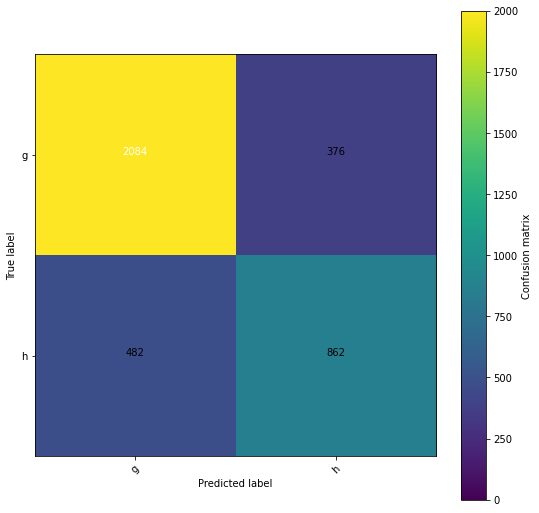

In [ ]:
print("confusion matrix: {}".format(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))))
plt.figure(figsize=(9,9))
_ = plot_confusion_matrix( confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)),le.classes_)

### Compute  the Area Under the Curve (AUC) 
(information already present in the figure of the ROC curve).

In [ ]:
a,u,c=rocData( y_test, predictions, le.classes_)

In [ ]:
print(c)

{'g': 0.8241210559427024, 'h': 0.8241210559427022}


### Classification report

The classification report provides a breakdown of each class by precision, recall, f1-score(harmonic mean between precision and recall) and support(the number of samples of the true response that lie in that class) showing excellent results (granted the validation dataset was small).

In [ ]:
print("classification report: {}".format(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))))

classification report:               precision    recall  f1-score   support

           0       0.81      0.85      0.83      2460
           1       0.70      0.64      0.67      1344

    accuracy                           0.77      3804
   macro avg       0.75      0.74      0.75      3804
weighted avg       0.77      0.77      0.77      3804



# **Create the model with pruning**

Here it is applied pruning to the baseline model. 
The Neural Network model built untill now can be optimized via weight pruning, which consists of reducing the number of parameters and operations involved in the computation, by removing unnecessary connections (and then parameters), in between NN layers. This allows to minimize the resource utilization. 
The pruning is done during the training process to allow the NN to adapt to the changes.

In [ ]:
from tensorflow.python.keras.models import Model
import tempfile
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from callbacks import all_callbacks
from tensorflow.keras.callbacks import Callback, EarlyStopping,History
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
import tempfile
logdir = tempfile.mkdtemp()
pruning_params = {" pruning_schedule " : 
                  tfmot.sparsity.keras.ConstantSparsity(0.75,
                  begin_step=2000,
                  frequency=100)}
model_for_pruning = prune_low_magnitude (model , **pruning_params )
print(pruning_params)


adam = Adam( lr =0.001)
model_for_pruning.compile( loss=['categorical_crossentropy'], optimizer=adam)
#model_for_pruning.compile( loss=tf.keras.losses.MeanSquaredError(), optimizer=adam)
model_for_pruning.summary()

     |████████████████████████████████| 234 kB 5.3 MB/s 


/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


{' pruning_schedule ': <tensorflow_model_optimization.python.core.sparsity.keras.pruning_schedule.ConstantSparsity object at 0x7f138e547590>}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_fc1 (Pr  (None, 64)               1346      
 uneLowMagnitude)                                                
                                                                 
 prune_low_magnitude_relu1 (  (None, 64)               1         
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_fc2 (Pr  (None, 32)               4130      
 uneLowMagnitude)                                                
                                                                 
 prune_low_magnitude_relu2 (  (None, 32)               1         
 PruneLowMagnitude)                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Train the model against baseline

In [ ]:
from sklearn.metrics import mean_squared_error

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
model_for_pruning.fit(X_train_val, y_train_val, 
                      batch_size=1028, 
                      epochs=100, 
                      validation_split=0.25,
                      callbacks=callbacks)

Epoch 1/100
12/12 [==============================] - 8s 50ms/step - loss: 1.3245 - val_loss: 0.9580
Epoch 2/100
12/12 [==============================] - 0s 13ms/step - loss: 0.7617 - val_loss: 0.6693
Epoch 3/100
12/12 [==============================] - 0s 20ms/step - loss: 0.6054 - val_loss: 0.5799
Epoch 4/100
12/12 [==============================] - 0s 11ms/step - loss: 0.5498 - val_loss: 0.5533
Epoch 5/100
12/12 [==============================] - 0s 12ms/step - loss: 0.5261 - val_loss: 0.5459
Epoch 6/100
12/12 [==============================] - 0s 22ms/step - loss: 0.5211 - val_loss: 0.5385
Epoch 7/100
12/12 [==============================] - 0s 17ms/step - loss: 0.5146 - val_loss: 0.5531
Epoch 8/100
12/12 [==============================] - 0s 13ms/step - loss: 0.5185 - val_loss: 0.5435
Epoch 9/100
12/12 [==============================] - 0s 12ms/step - loss: 2.5258 - val_loss: 2.7200
Epoch 10/100
12/12 [==============================] - 0s 13ms/step - loss: 1.4208 - val_loss: 1.0726

## Preditions

In [ ]:
y_pruned_predictions = model_for_pruning.predict(np.ascontiguousarray(X_test))

## Evaluation of the model against the baseline.

The accuracy after pruning improves:

In [ ]:
print("Accuracy with pruned model: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pruned_predictions, axis=1))))

Accuracy with pruned model: 0.8275499474237644


### ROC curve

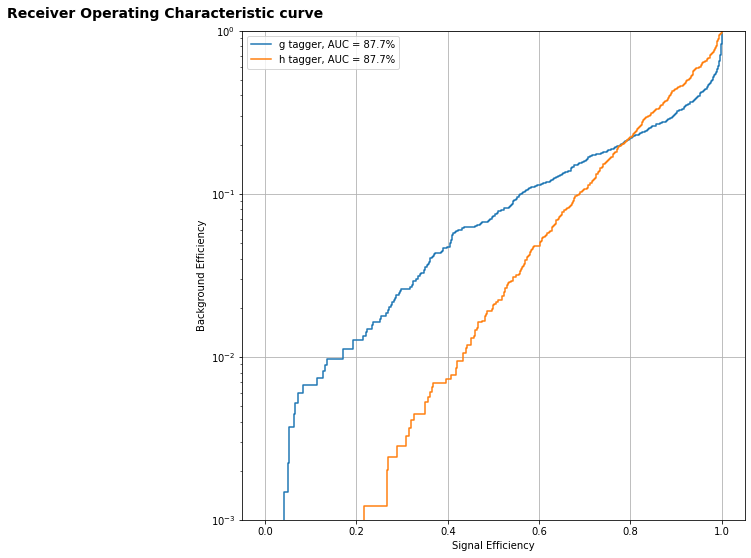

In [ ]:
plt.figure(figsize=(9,9))
_ = makeRoc(y_test, y_pruned_predictions, le.classes_)

### Confusion matrix

confusion matrix: [[2274  186]
 [ 470  874]]


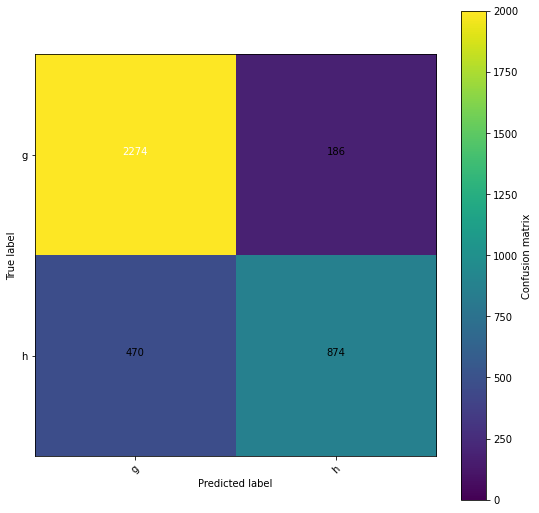

In [ ]:
print("confusion matrix: {}".format(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pruned_predictions, axis=1))))
plt.figure(figsize=(9,9))
_ = plot_confusion_matrix( confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pruned_predictions, axis=1)),le.classes_)

### Classification report

In [ ]:
print("classification report: {}".format(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pruned_predictions, axis=1))))

classification report:               precision    recall  f1-score   support

           0       0.83      0.92      0.87      2460
           1       0.82      0.65      0.73      1344

    accuracy                           0.83      3804
   macro avg       0.83      0.79      0.80      3804
weighted avg       0.83      0.83      0.82      3804

